In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
# The train data points are spaced every 1/25 between 0 and 1 inclusive
train_x = Variable(torch.linspace(0, 1, 26))
# Use the sign function (-1 if value <0, 1 if value>0) to assign periodic labels to the data
train_y = Variable(torch.sign(torch.cos(train_x.data * (8 * math.pi))))

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
# Create a model to classify, we use a GridInducingVariationalGP which exploits
# grid structure (the x data points are linspace)
# to get fast predictive distributions
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=32, grid_bounds=[(0, 1)])
        # Near-zero constant mean
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        # RBF kernel as universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        # Register RBF lengthscale as hyperparameter
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        # Calc predictive mean (zero)
        mean_x = self.mean_module(x)
        # Calc predictive covariance
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # Make predictive distribution from predictive mean and covariance
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

# Initialize model
model = GPClassificationModel()
# Use Bernoulli Likelihood (warps via normal CDF to (0,1))
likelihood = BernoulliLikelihood()

In [8]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0

def train():
    num_iter = 200
    for i in range(num_iter):
        # Zero gradients out for new iteration
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calculate loss
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        # Calc gradients
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f' % (
            i + 1, num_iter, loss.data[0],
            model.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
        ))
        optimizer.step()
# Get clock time
%time train()

RuntimeError: calling resize_ on a tensor that has non-resizable storage. Clone it first or create a new tensor instead.

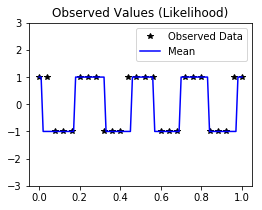

In [6]:
# Set model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize axes
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are every 0.01 from 0 to 1 inclusive 
test_x = Variable(torch.linspace(0, 1, 101))
# Make predictions from model output Gaussian warped through Bernoulli likelihood
predictions = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Black stars for trainng data
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Based of prediction probability label -1 or 1
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
    # Plot test predictions as blue line
    ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
    
# Call plot
ax_plot(observed_ax, predictions, 'Observed Values (Likelihood)')